In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from datetime import date

In [3]:
today = pd.Timestamp(date.today())

In [4]:
# Custom formatter function to remove trailing zeros
def format_float(x):
    return '{:.3f}'.format(x).rstrip('0').rstrip('.')
# Set the display format for floating-point numbers
pd.options.display.float_format = format_float

In [5]:
# Please not that fredapi requires python 3.8 or earlier!
import yfinance as yf
from fredapi import Fred

# Load data from FRED

In [6]:
# initalize FRED API KEY
fred = Fred(api_key='a3b03d28aacddb7101ca16959931d57b')

In [7]:
# Load a few data from FRED

In [8]:
DFF = fred.get_series('DFF') #  – Interest Rates, Discount Rate for United States (Units: Percent per Annum)

In [9]:
DTB3 = fred.get_series('DTB3') #  – 3-Month Treasury Bill Secondary Market Rate, Discount Basis
# DTB3 resembles DFF. I will use it to reconstruct T10Y3M only

In [10]:
DGS10 = fred.get_series('DGS10') # Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis

In [11]:
#T10Y3M = fred.get_series('T10Y3M').dropna() # Spread between TR10 and 3M
# I've decided not to use this data because it starts from 1982 but can be replaced by T10_3 = DGS10-DTB3

In [12]:
UNRATE = fred.get_series('UNRATE') # unemployement rate the data has 1 month missing - to look later

In [13]:
ICNSA = fred.get_series('ICNSA') # initial unemployement claims

In [14]:
ACOGNO = fred.get_series('ACOGNO') # Manufacturers' New Orders: Consumer Goods - lack of fresh data, find another one

In [15]:
NEWORDER = fred.get_series('NEWORDER') #  Manufacturers' New Orders: Capital Goods - lack of 2 months data, look at it later

In [16]:
AWHMAN = fred.get_series('AWHMAN') - 40 # Average Weekly Hours Mfg, normalized

In [17]:
PERMIT = fred.get_series('PERMIT') # Building Permits

In [18]:
# PPIACO = fred.get_series('PPIACO').dropna() # Producer Price Index - I excluded due to high multicolinearity

In [19]:
UMCSENT = fred.get_series('UMCSENT') #  University of Michigan: Consumer Sentiment without last math - it should be taken from site

In [20]:
BUSLOANS = fred.get_series('BUSLOANS') # Commercial and Industrial Loans, All Commercial Banks

In [21]:
#MPRIME = fred.get_series('MPRIME') # Bank Prime Load Rate - excluded due to high multicolinearity

In [22]:
#FEDFUNDS = fred.get_series('FEDFUNDS') # Federal Funds Effective Rate - excluded due to high multicolinearity

In [23]:
CURRCIR = fred.get_series('CURRCIR') # Currency in Circulation 

In [24]:
WM2NS = fred.get_series('WM2NS') # M2 Money

In [25]:
PSAVERT = fred.get_series('PSAVERT') # Personal Saving Rate

In [26]:
#IC4WSA = fred.get_series('IC4WSA') # 4 Initial Claims 4 MA - excluded due to high correlation

In [27]:
CPIAUCSL = fred.get_series('CPIAUCSL') # CPI

In [28]:
BBKMLEIX = fred.get_series('BBKMLEIX') # Brave-Butters-Kelley Leading Index

In [29]:
GDP = fred.get_series('GDP').dropna() #  GDP

# Here is the calculation of the derived KPI and features

In [30]:
# Rate of change in liquidity in comparison with a year ago 
LiqChg = CURRCIR / CURRCIR.shift(12) - 1

In [31]:
# Rate of change in M2 liquidity
M2Chg = WM2NS / WM2NS.shift(12) - 1

In [32]:
# Rate of change in Business investment
BusInvChg = BUSLOANS / BUSLOANS.shift(12) - 1

In [33]:
# Rate of Inflation YoY
Infl = CPIAUCSL / CPIAUCSL.shift(12) - 1

In [34]:
# Consumer Orders in $$ Adjusted for Inflation
ACOGNO = ACOGNO / CPIAUCSL

In [35]:
# the Capital Goods orders in $$ Adjusted  for inflation
NEWORDER = NEWORDER / CPIAUCSL

In [36]:
T10_3 = DGS10 - DTB3 # Diff in Yields of Treasury 10Y and 3Months. So called yield curve as recession predictor

In [37]:
# Form the first data frame of FRED features
df = pd.concat([DFF,  DGS10,  T10_3,  UNRATE,  ICNSA,  ACOGNO,  NEWORDER,  AWHMAN,  PERMIT,  UMCSENT,  BusInvChg,  LiqChg,  M2Chg,  PSAVERT,  Infl,  BBKMLEIX], axis=1)
df.columns = [ 'DFF','DGS10','T10_3','UNRATE','ICNSA','ACOGNO','NEWORDER','AWHMAN','PERMIT','UMCSENT','BusInvChg','LiqChg','M2Chg','PSAVERT','Infl','BBKMLEIX']

In [38]:
# Dump downloaded fred data for further analysis 
df.to_excel('fred_data.xlsx')

The FRED data sometimes does not have data for last two months for some indicators.
So I will try to solve a slightly different task: In what extent the economic data impacts on stock market medium term?

## Load high frequency data like SP500 index from Yahoo! Finance

In [39]:
# Load SP500 index data
sp500 = yf.Ticker("^GSPC")

In [40]:
sp500 = sp500.history(period='max')

In [41]:
# fix issue with time zome to use excel as data visualizer
sp500.index = sp500.index.tz_localize(None)

In [42]:
price = sp500['Close']

In [43]:
volume = sp500['Volume']

In [44]:
vol_n = sp500['Volume'] / sp500['Volume'].rolling(window=20).mean() - 1

In [45]:
ma20 = sp500['Close'].rolling(window=20).mean()

In [46]:
ma20gr = (ma20 - ma20.shift(20))/ma20

In [47]:
# the future direction of ma20
ma20gr_fut = (ma20.shift(-20) - ma20)/ma20

In [48]:
dir_fut = ma20gr_fut.apply(lambda x: 1 if x >= 0 else -1)

In [49]:
# Load VIX

In [50]:
vix = yf.Ticker("^VIX").history(period='max')['Close']

In [51]:
vix.index = vix.index.tz_localize(None)

In [52]:
# A few features based on stock prices for trend learning

In [53]:
pr_0 = (price - ma20)/ma20

In [54]:
pr_1 = (price.shift(1) - ma20)/ma20

In [55]:
pr_2 = (price.shift(2) - ma20)/ma20

In [56]:
pr_3 = (price.shift(3) - ma20)/ma20

In [57]:
pr_4 = (price.shift(4) - ma20)/ma20

In [58]:
pr_5 = (price.shift(5) - ma20)/ma20

In [59]:
pr_6 = (price.shift(6) - ma20)/ma20

In [60]:
pr_7 = (price.shift(7) - ma20)/ma20

In [61]:
pr_8 = (price.shift(8) - ma20)/ma20

In [62]:
pr_9 = (price.shift(9) - ma20)/ma20

In [63]:
pr_10 = (price.shift(10) - ma20)/ma20

In [64]:
dfp = pd.concat([vol_n, ma20gr, vix, pr_0, pr_1, pr_2, pr_3, pr_4, pr_5, pr_6, pr_7, pr_8, pr_9, pr_10, ma20gr_fut, dir_fut], axis=1)

In [65]:
dfp.columns = ['vol_n', 'ma20gr', 'vix', 'pr_0', 'pr_1', 'pr_2', 'pr_3', 'pr_4', 'pr_5', 'pr_6', 'pr_7', 'pr_8', 'pr_9', 'pr_10', 'ma20gr_fut','dir_fut']

## Data trimming ##
until now nothing was trimmed in data, now I would like to cut records to the working dataset

In [66]:
df.fillna(method='ffill', inplace=True)

In [67]:
ds = pd.concat([df, dfp], axis=1)

In [68]:
ds.to_excel('ds.xlsx')

In [69]:
ds = ds.dropna()

In [70]:
# The dataset has a data from .. to ..
start_date = '1992-02-03'
end_date = '2024-07-01'

In [71]:
ds = ds.loc[start_date:end_date]

In [72]:
ds.to_excel('dataset.xlsx')

In [73]:
ds

,DFF,DGS10,T10_3,UNRATE,ICNSA,ACOGNO,NEWORDER,AWHMAN,PERMIT,UMCSENT,...,pr_3,pr_4,pr_5,pr_6,pr_7,pr_8,pr_9,pr_10,ma20gr_fut,dir_fut
1992-02-03,4,7.36,3.52,7.4,508594,623.701,244.278,0.7,1146,68.8,...,-0.012,-0.001,-0.001,0,-0.001,0.006,-0.007,0.002,-0.007,-1
1992-02-04,3.83,7.29,3.45,7.4,508594,623.701,244.278,0.7,1146,68.8,...,-0.009,-0.012,-0.001,-0.001,0.001,-0.001,0.007,-0.006,-0.007,-1
1992-02-05,4.17,7.21,3.37,7.4,508594,623.701,244.278,0.7,1146,68.8,...,-0.015,-0.008,-0.011,-0,-0,0.001,-0,0.007,-0.007,-1
1992-02-06,4.1,7.2,3.39,7.4,508594,623.701,244.278,0.7,1146,68.8,...,-0.013,-0.015,-0.008,-0.011,0,0,0.002,0,-0.008,-1
1992-02-07,3.89,7.2,3.46,7.4,508594,623.701,244.278,0.7,1146,68.8,...,-0.002,-0.012,-0.014,-0.007,-0.01,0.001,0.001,0.002,-0.008,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-25,5.33,4.23,-1,4.1,225100,798.974,236.107,0.8,1454,68.2,...,0.018,0.02,0.018,0.01,0.01,0.008,-0,-0.003,0.032,1
2024-06-26,5.33,4.32,-0.92,4.1,225100,798.974,236.107,0.8,1454,68.2,...,0.015,0.016,0.019,0.016,0.008,0.009,0.006,-0.002,0.029,1
2024-06-27,5.33,4.29,-0.94,4.1,225100,798.974,236.107,0.8,1454,68.2,...,0.009,0.013,0.014,0.017,0.014,0.006,0.007,0.004,0.027,1
2024-06-28,5.33,4.36,-0.86,4.1,225100,798.974,236.107,0.8,1454,68.2,...,0.011,0.007,0.01,0.012,0.015,0.012,0.004,0.005,0.025,1


In [74]:
# Save SP500 pricing data for trading emulation
sp500[['Open','Close']].loc[start_date:end_date].to_excel('sp500.xlsx')

# Check features for the multicolinearity

In [75]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [76]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = ds.columns
  # calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(ds.values, i)
                          for i in range(len(ds.columns))]

In [77]:
vif_data

,feature,VIF
0,DFF,224.112
1,DGS10,375.613
2,T10_3,83.442
3,UNRATE,97.712
4,ICNSA,8.44
5,ACOGNO,183.272
6,NEWORDER,354.425
7,AWHMAN,21.552
8,PERMIT,45.581
9,UMCSENT,200.643


# Some plots

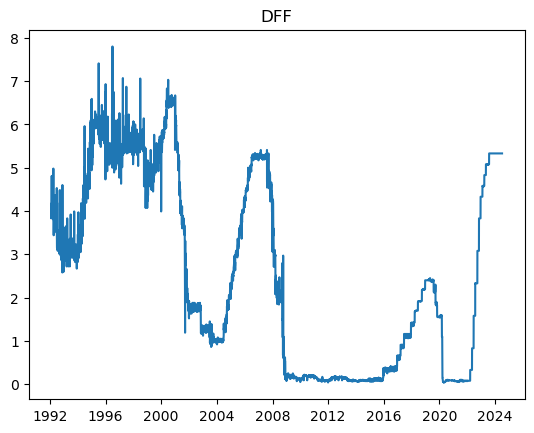

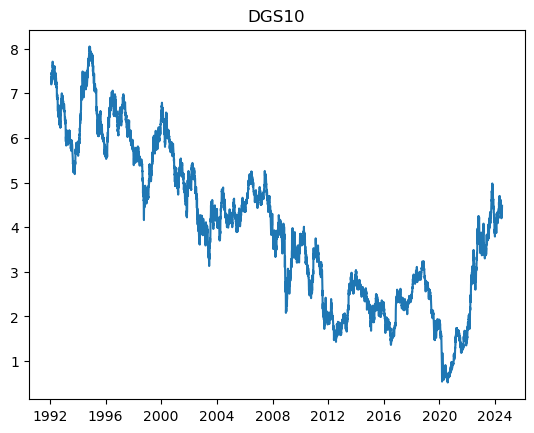

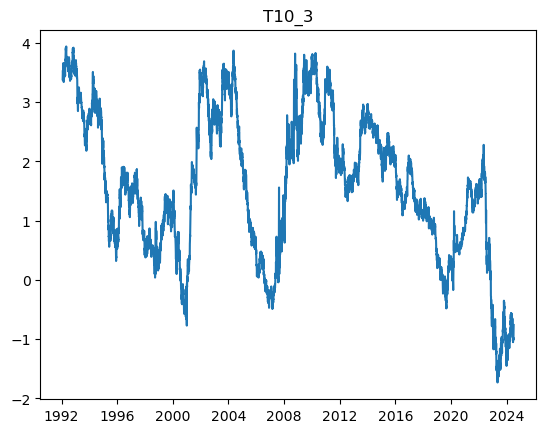

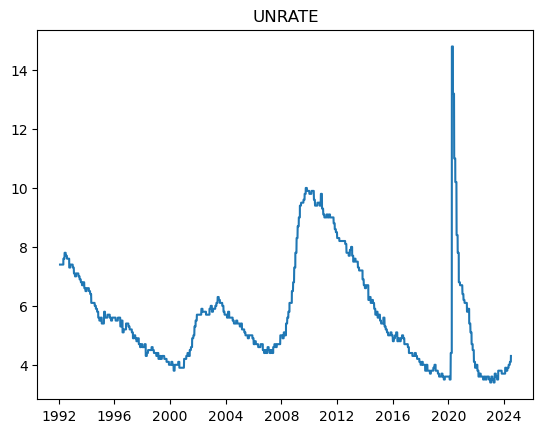

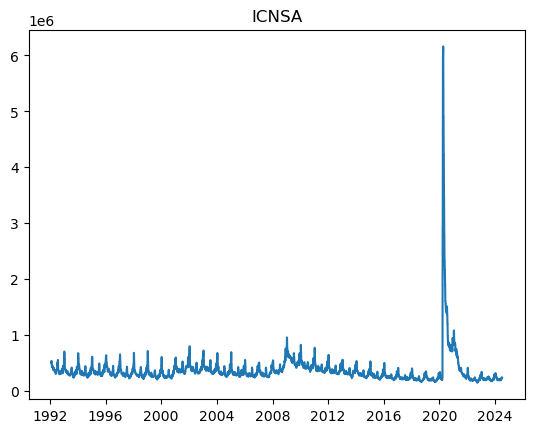

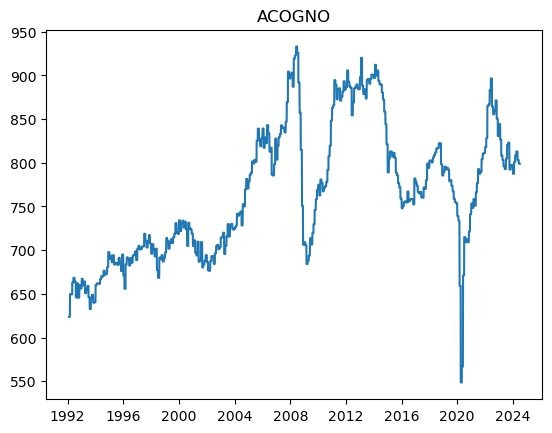

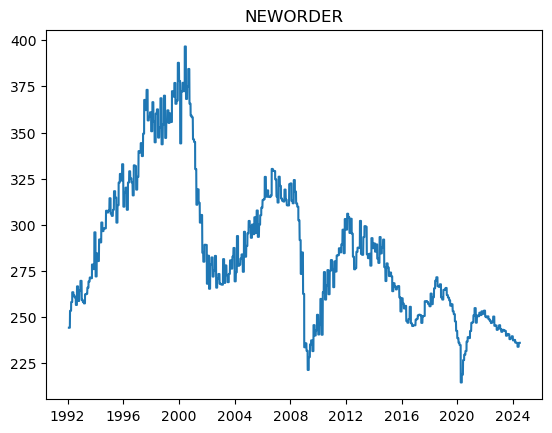

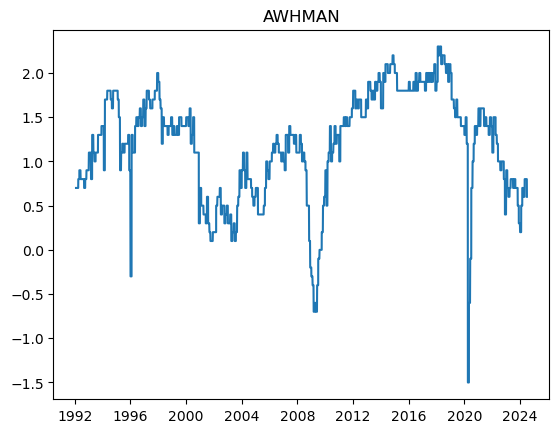

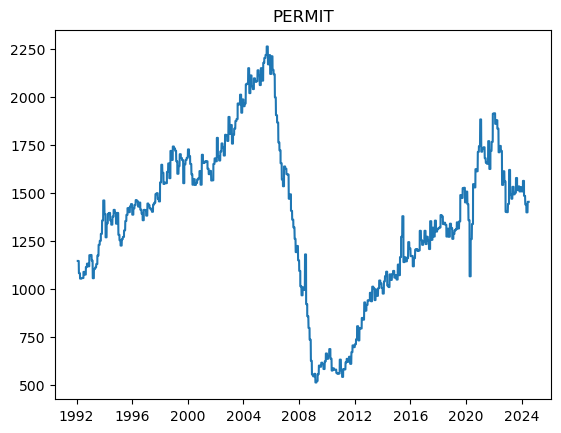

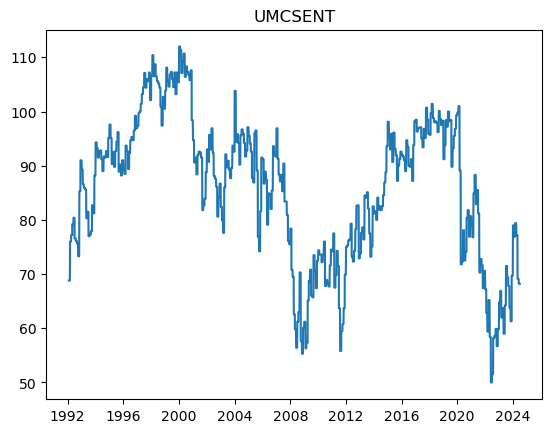

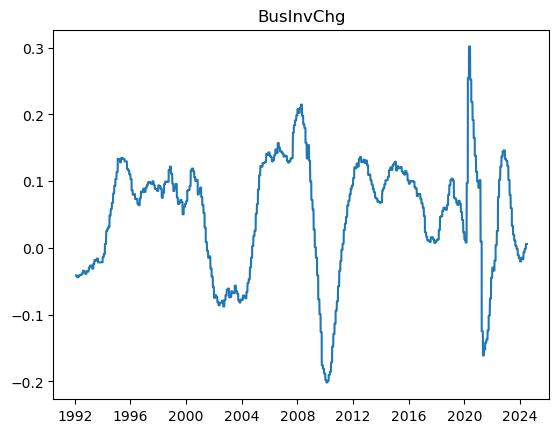

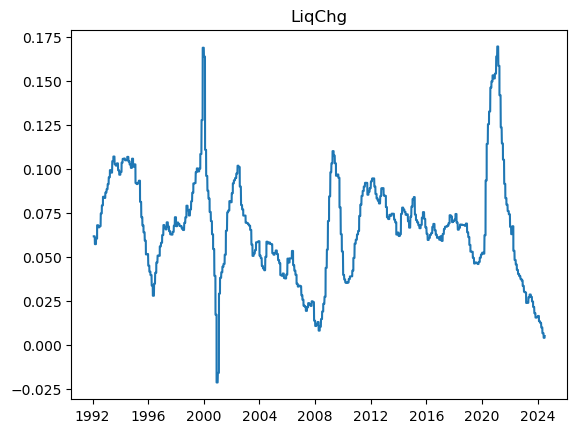

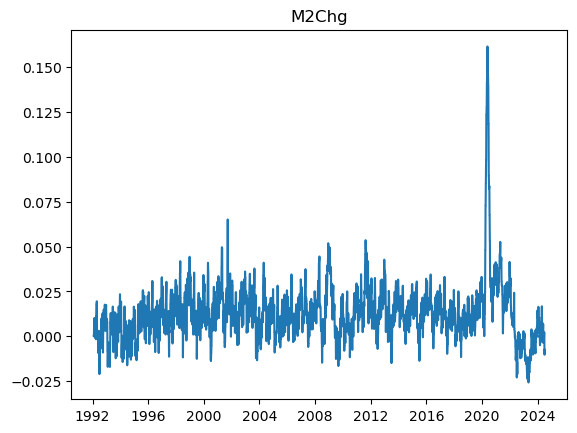

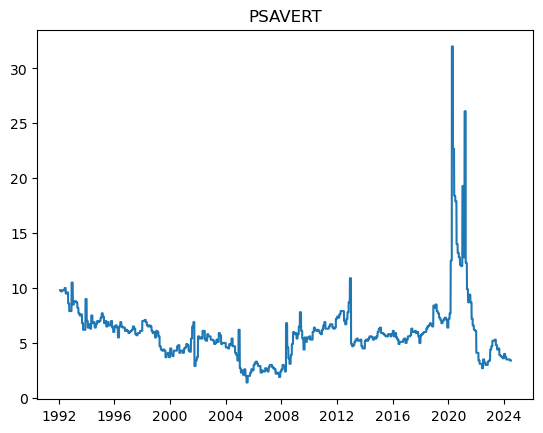

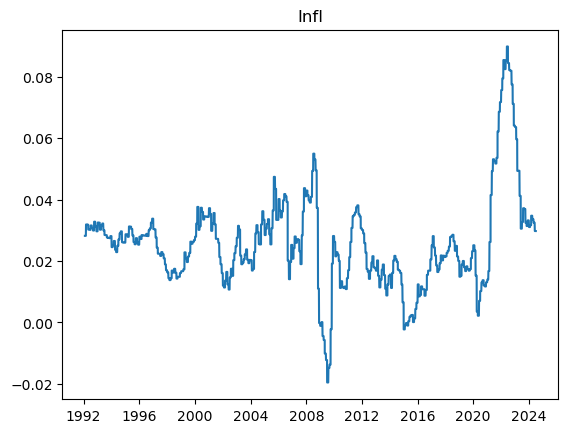

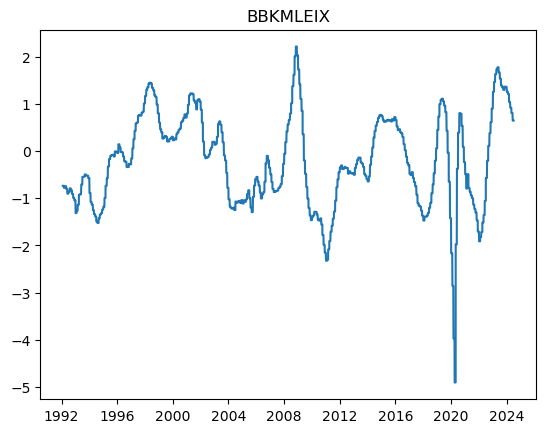

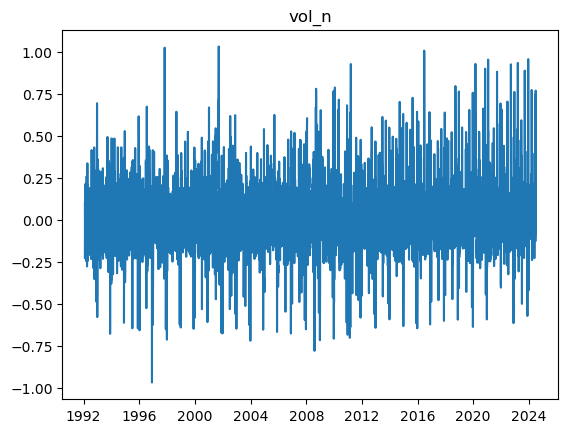

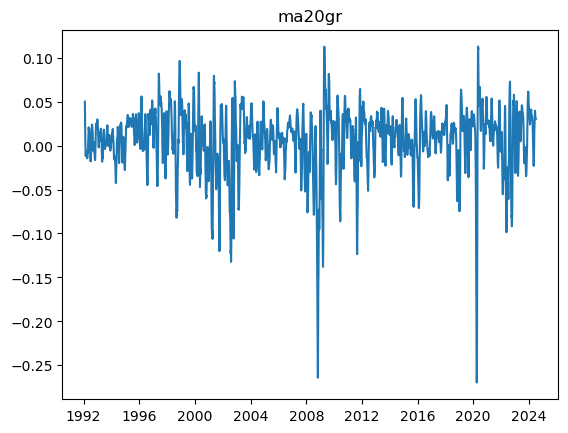

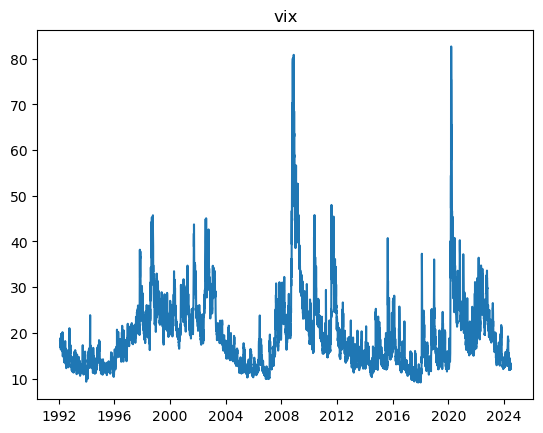

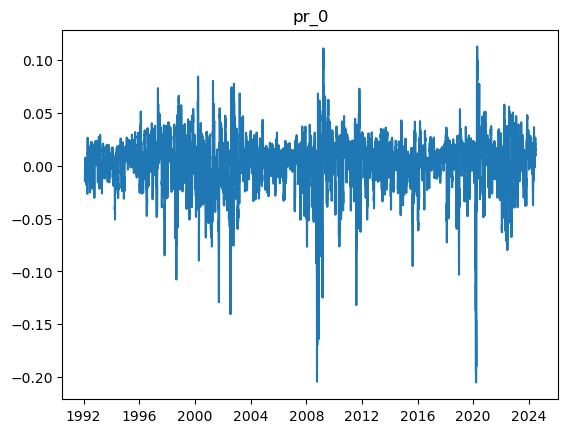

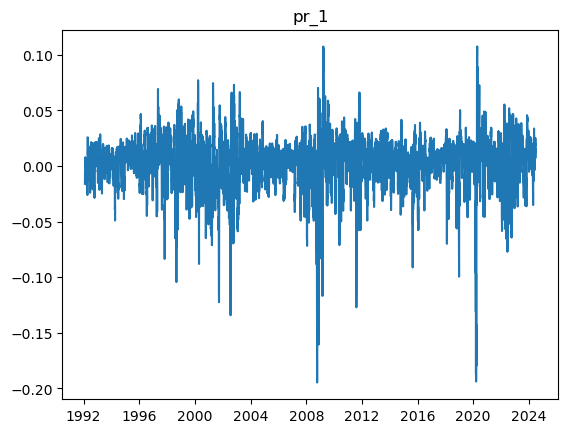

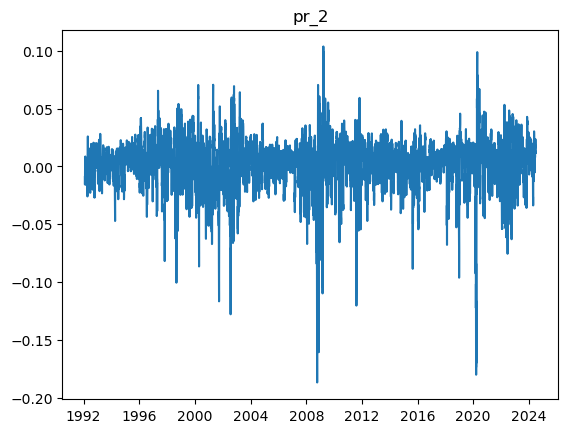

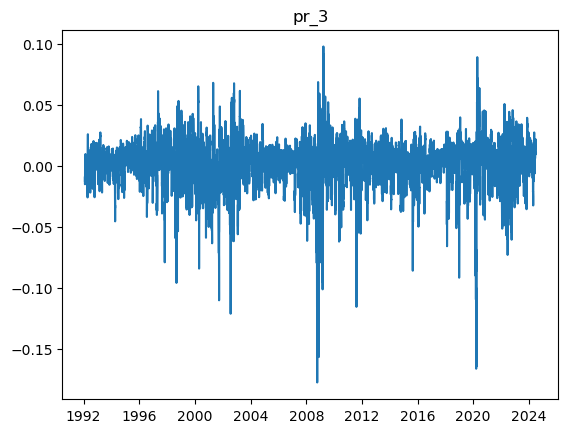

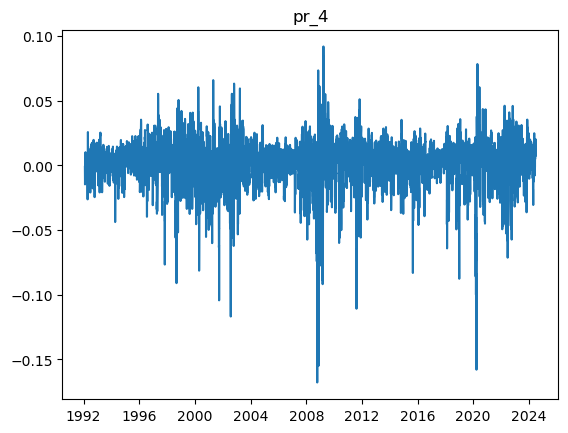

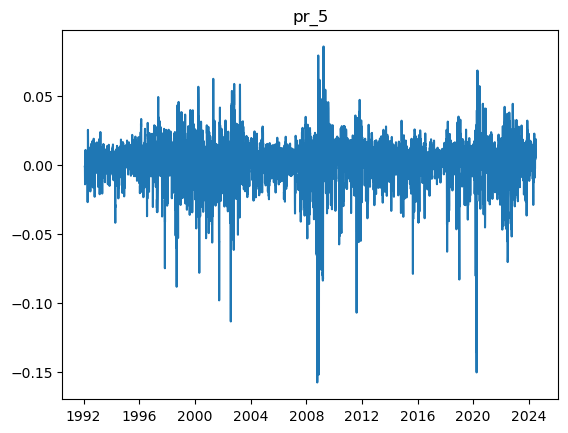

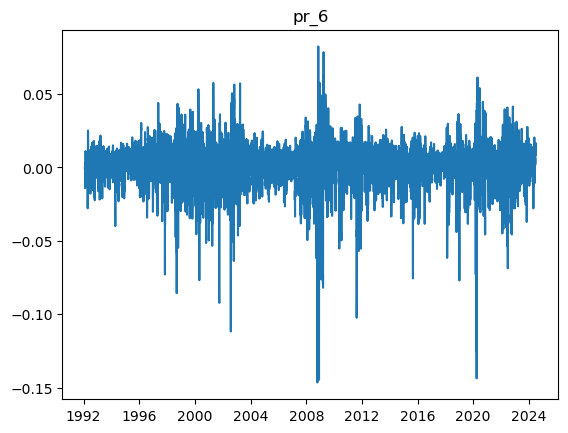

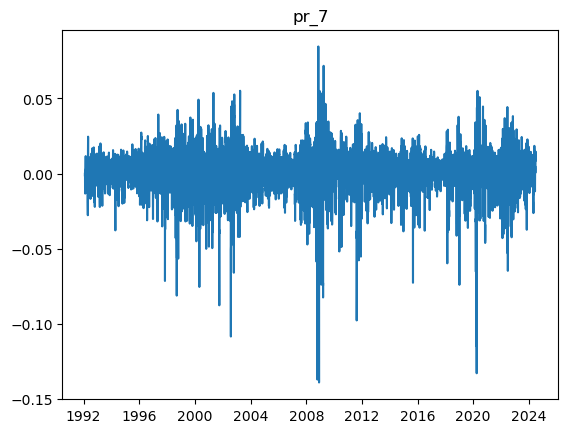

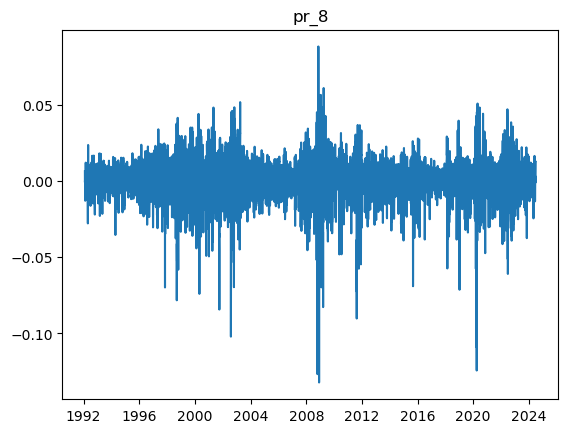

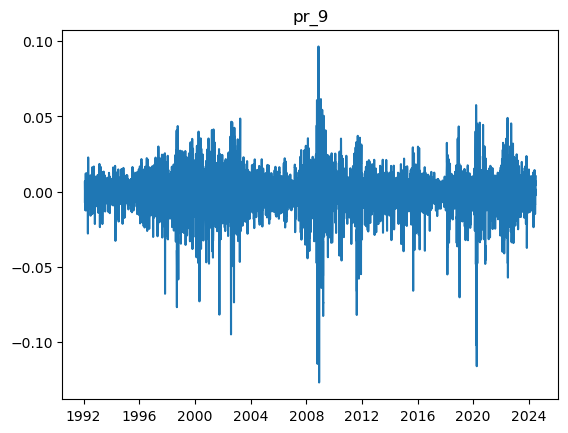

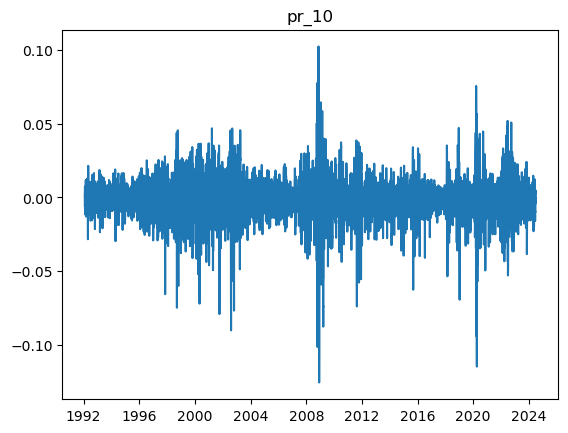

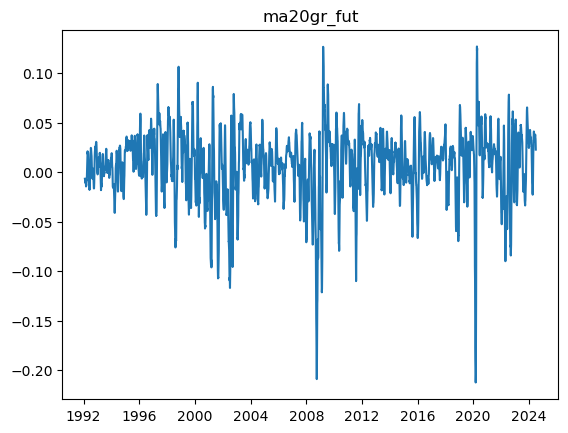

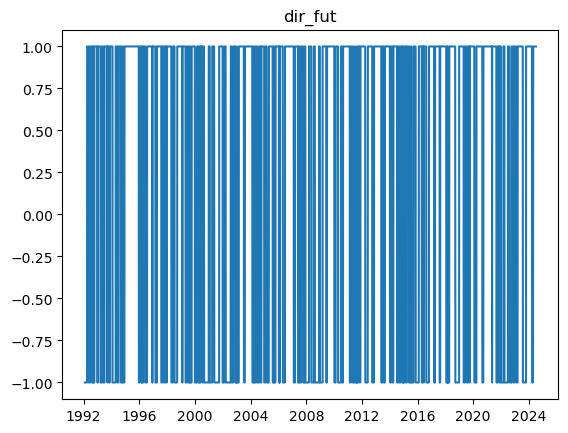

In [78]:
for name in ds.columns: 
    plt.plot(ds[name])
    plt.title(name)
    plt.show()